In [1]:
import os
from typing import List

import numpy as np
import pandas as pd

from Bio import SeqIO

import torch
import torch.nn as nn
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from torch import optim
# from torch.utils.data import DataLoader

# from dataset.domainLinker_dataset import DomainLinkerDataset, Sequence, collate_fn
from dataset.utils import read_plm

from utils.common import dump_list2json, read_json2list
import params.filePath as paramF
import params.hyperparams as paramH

import json

from model.utils import load_model
from utils.static import type_dataset
from utils.ensemble import generate_models, ensemble_predict

Using device: cuda


# Aim of this Notebook



In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


**Parameters**

In [3]:
ensemble_name = 'ensemble: protTransL12'

# 0. Functions

In [4]:
# 1. get label
def get_label(dict_entity):

    '''
    Generate entity labels.
    params:
        dict_entity - dict, {'id': str, 'sequence':str, 'reference': str}. reference is the label.
    return:
        label - list of labels. [0 or 1, ...]
    '''
    label = dict_entity['reference']
    label = [int(l) for l in label]
    return label

def get_pred_label(pred, threshold=0.1):
    '''
    params:
        pred - predicted list
        label - ground truth
        threshold - better to set the threshold which make the precision similar to recall. (a higher F1 score.)
    return:
        pred_label - list, classification label generate from pred given threshold
    '''
    pred_label = [1 if i>threshold else 0 for i in pred]

    return pred_label

def get_idrIdx(pred_label):
    '''
    pdb atom index: _atom_site.label_seq_id (not author index)
    '''
    return [i+1 for i, e in enumerate(pred_label) if e == 1]

# 3. errors
def count_mispredict(pred_label, label):
    return sum(abs(np.array(label) - np.array(pred_label)))
def error_mispredict(pred, label):
    return sum(abs(np.array(label) - np.array(pred)))/len(label)

# 4. find index based on entity id
def get_idxByID(entity_id):
    for idx, entity in enumerate(list_test_entity):
        if entity_id==entity['id']:
            return idx

# 1. Predictors

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [6]:
paramH.dict_featureType

{1: 'onehot',
 2: 'hmm_prob_numTemp',
 3: 'hmm_aa_numTemp',
 4: 'protTrans',
 5: 'esm2',
 6: 'msa_transformer',
 7: 'hmm_prob',
 8: 'hmm_aa',
 9: 'hmm_prob@onehot',
 10: 'hmm_prob_numTemp@onehot',
 11: 'protTrans@onehot',
 12: 'esm2@onehot',
 13: 'msa_transformer@onehot',
 14: 'msa_transformer@hmm_prob_numTemp',
 15: 'protTrans@hmm_prob_numTemp',
 16: 'protTrans@msa_transformer'}

In [7]:
type_dataset.ALL_FD_78

'withFullyDisorder78'

In [265]:
datasetType = type_dataset.ALL_FD_78
datasetType_2 = type_dataset.ALL_FD
netName = 'model.cnn2_L12'
netName_L11 = 'model.cnn2_L11'
netName_L13 = 'model.cnn2_L13'
netName_L3 = 'model.cnn2_L3_100_50'

# lstm belongs to RNN category. 
NNtype_list = ['cnn', 'rnn', 'cbrcnn']
net_type = NNtype_list[0]

# model_pth = os.path.join(path_output, f'trained_model/{featureType}/{model_name}.pth')
list_modelInfo_onehot = [{'model_name':f'{netName[6:]}_{datasetType}', 'fold': f'_f{k}', 'net_name': netName, 'net_type': NNtype_list[0], 'lr':paramH.lr, 'dropout':paramH.dropout, 'featureType': paramH.dict_featureType[1]} for k in range(1, 4)]
# list_modelInfo_protTrans_3 = [{'model_name':f'{netName_L11[6:]}_{datasetType}', 'fold': f'_f{k}', 'net_name': netName_L11, 'net_type': NNtype_list[0], 'lr':paramH.lr, 'dropout':paramH.dropout, 'featureType': paramH.dict_featureType[4]}  for k in range(1, 6)]
list_modelInfo_protTrans = [{'model_name':f'{netName[6:]}_{datasetType}', 'fold': f'_f{k}', 'net_name': netName, 'net_type': NNtype_list[0], 'lr':paramH.lr, 'dropout':paramH.dropout, 'featureType': paramH.dict_featureType[4]}  for k in range(1, 6)]
list_modelInfo_protTrans_2 = [{'model_name':f'{netName_L3[6:]}_{datasetType}', 'fold': f'_f{k}', 'net_name': netName_L3, 'net_type': NNtype_list[0], 'lr':paramH.lr, 'dropout':paramH.dropout, 'featureType': paramH.dict_featureType[4]}  for k in range(1, 6)]

list_modelInfo_msaTransformer = [{'model_name':f'{netName_L11[6:]}_{datasetType}', 'fold': f'_f{k}', 'net_name': netName_L11, 'net_type': NNtype_list[0], 'lr':paramH.lr, 'dropout':paramH.dropout, 'featureType': paramH.dict_featureType[6]}  for k in range(1, 6)]
list_modelInfo_msaTransformer_2 = [{'model_name':f'{netName_L11[6:]}_{datasetType_2}', 'fold': f'_f{k}', 'net_name': netName_L11, 'net_type': NNtype_list[0], 'lr':paramH.lr, 'dropout':paramH.dropout, 'featureType': paramH.dict_featureType[6]}  for k in range(1, 6)]

list_modelInfo =list_modelInfo_onehot + list_modelInfo_protTrans + list_modelInfo_protTrans_2 + list_modelInfo_msaTransformer_2

models = generate_models(list_modelInfo)

=> loading checkpoint '/home/dimeng/project/idr/predictor_v3/output/trained_model/onehot/cnn2_L12_withFullyDisorder78.pth_f1'
=> loaded checkpoint '0.04363326595568851' (epoch 150)
=> loading checkpoint '/home/dimeng/project/idr/predictor_v3/output/trained_model/onehot/cnn2_L12_withFullyDisorder78.pth_f2'
=> loaded checkpoint '0.04369498302361795' (epoch 150)
=> loading checkpoint '/home/dimeng/project/idr/predictor_v3/output/trained_model/onehot/cnn2_L12_withFullyDisorder78.pth_f3'
=> loaded checkpoint '0.04391429878923358' (epoch 150)
=> loading checkpoint '/home/dimeng/project/idr/predictor_v3/output/trained_model/protTrans/cnn2_L12_withFullyDisorder78.pth_f1'
=> loaded checkpoint '0.0338835282270117' (epoch 15)
=> loading checkpoint '/home/dimeng/project/idr/predictor_v3/output/trained_model/protTrans/cnn2_L12_withFullyDisorder78.pth_f2'
=> loaded checkpoint '0.03285686011627518' (epoch 15)
=> loading checkpoint '/home/dimeng/project/idr/predictor_v3/output/trained_model/protTrans/

# 2. Test

## 2.1. CAID dataset

In [266]:
list_entity = read_json2list(paramF.path_caid_dataset_json)
df_caid= pd.DataFrame(read_json2list(paramF.path_caid_dataset_json))
list_seq_all = list(df_caid['id'])

In [267]:
len(list_entity), len(list_seq_all)

(348, 348)

In [268]:
df_caid

,id,sequence,length,reference,info_idr,num_idr,len_1022
0,DP02342,MLCCMRRTKQVEKNDEDQKIEQDGVKPEDKAHKAATKIQASFRGHI...,227,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{'1': {'start': 0, 'end': 226, 'len_linker': 2...",1,1
1,DP02348,MAPVSGSRSPDREASGSGGRRRSSSKSPKPSKSARSPRGRRSRSHS...,415,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{'1': {'start': 0, 'end': 414, 'len_linker': 4...",1,1
2,DP02361,MSALRRSGYGPSDGPSYGRYYGPGGGDVPVHPPPPLYPLRPEPPQP...,457,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","{'1': {'start': 356, 'end': 375, 'len_linker':...",1,1
3,DP02364,MADLANEEKPAIAPPVFVFQKDKGQKRSAGGSSPEGGEDSDREDGN...,499,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","{'1': {'start': 30, 'end': 44, 'len_linker': 15}}",1,1
4,DP02376,MDGPGASAVVVRVGIPDLQQTKCLRLDPTAPVWAAKQRVLCALNHS...,1730,"[-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'1': {'start': 376, 'end': 531, 'len_linker':...",5,0
...,...,...,...,...,...,...,...
343,DP03741,MGAQVSSQKVGAHENSNRAYGGSTINYTTINYYRDSASNAASKQDF...,2209,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'1': {'start': 1456, 'end': 1468, 'len_linker...",2,0
344,DP03742,MGARNSVLRGKKADELERIRLRPGGKKKYRLKHIVWAANKLDRFGL...,1464,"[-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'1': {'start': 110, 'end': 134, 'len_linker':...",1,0
345,DP03743,MSKVIQKKNHWTSRVHECTVKRGPQGELGVTVLGGAEHGEFPYVGA...,1491,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","{'1': {'start': 554, 'end': 579, 'len_linker':...",1,0
346,DP03744,MHKCAIFLLLALSCQQIQAELTAADCRALGFIKAQLMCSSCEKLDD...,178,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","{'1': {'start': 16, 'end': 60, 'len_linker': 4...",2,1


In [269]:
df_caid[df_caid['id']=='DP02411']['sequence']

9    MKTSPRRPLILKRRRLPLPVQNAPSETSEEEPKRSPAQQESNQAEA...
Name: sequence, dtype: object

## 2.2. Prediction

In [270]:
path_pred_caid = os.path.join(paramF.path_pred_files, f'caid_pred_{ensemble_name}.json')

In [271]:
'''
list_predInfo = []
list_seq_id = []
for entity in list_entity:
    entity_id = entity['id']
    entity_seq = entity['sequence']
    label = get_label(entity)
    # get prediction
    if entity_id in list_seq_len1022:
        avg_pred, true_label = ensemble_predict(models_OPM, list_modelInfo_OPM, entity_id, label)
    else:
        avg_pred, true_label = ensemble_predict(models_OP, list_modelInfo_OP, entity_id, label)
    
    avg_error = error_mispredict(avg_pred, true_label)
    
    predInfo = {'id': entity_id, 'seq_len': len(entity_seq), 'true_pred': avg_pred.tolist(), 'true_reference': true_label, 'avg_error': float(avg_error)}
    
    list_predInfo.append(predInfo)
dump_list2json(list_predInfo, path_pred_caid)
'''

"\nlist_predInfo = []\nlist_seq_id = []\nfor entity in list_entity:\n    entity_id = entity['id']\n    entity_seq = entity['sequence']\n    label = get_label(entity)\n    # get prediction\n    if entity_id in list_seq_len1022:\n        avg_pred, true_label = ensemble_predict(models_OPM, list_modelInfo_OPM, entity_id, label)\n    else:\n        avg_pred, true_label = ensemble_predict(models_OP, list_modelInfo_OP, entity_id, label)\n    \n    avg_error = error_mispredict(avg_pred, true_label)\n    \n    predInfo = {'id': entity_id, 'seq_len': len(entity_seq), 'true_pred': avg_pred.tolist(), 'true_reference': true_label, 'avg_error': float(avg_error)}\n    \n    list_predInfo.append(predInfo)\ndump_list2json(list_predInfo, path_pred_caid)\n"

In [272]:
list_predInfo = []
list_seq_id = []
msa_only = False

for entity in list_entity:
    msaTrans = True
    entity_id = entity['id']
    entity_seq = entity['sequence']
    label = get_label(entity)
    # entity_length = len(entity_seq)
    entity_length = entity['len_1022']
    if entity_length==0:
    # if entity_length>1022:
        msaTrans = False
        if msa_only:
            continue
            
    # get prediction
    avg_pred, true_label = ensemble_predict(models, list_modelInfo, entity_id, label, msaTrans_avail=msaTrans)
    avg_error = error_mispredict(avg_pred, true_label)
    
    predInfo = {'id': entity_id, 'seq_len': len(entity_seq), 'true_pred': avg_pred.tolist(), 'true_reference': true_label, 'avg_error': float(avg_error)}
    
    list_predInfo.append(predInfo)
dump_list2json(list_predInfo, path_pred_caid)

DP02376
skip msa
DP02376
skip msa
DP02376
skip msa
DP02376
skip msa
DP02376
skip msa
DP02377
skip msa
DP02377
skip msa
DP02377
skip msa
DP02377
skip msa
DP02377
skip msa
DP02393
skip msa
DP02393
skip msa
DP02393
skip msa
DP02393
skip msa
DP02393
skip msa
DP02401
skip msa
DP02401
skip msa
DP02401
skip msa
DP02401
skip msa
DP02401
skip msa
DP02418
skip msa
DP02418
skip msa
DP02418
skip msa
DP02418
skip msa
DP02418
skip msa
DP02542
skip msa
DP02542
skip msa
DP02542
skip msa
DP02542
skip msa
DP02542
skip msa
DP02567
skip msa
DP02567
skip msa
DP02567
skip msa
DP02567
skip msa
DP02567
skip msa
DP02571
skip msa
DP02571
skip msa
DP02571
skip msa
DP02571
skip msa
DP02571
skip msa
DP02601
skip msa
DP02601
skip msa
DP02601
skip msa
DP02601
skip msa
DP02601
skip msa
DP02604
skip msa
DP02604
skip msa
DP02604
skip msa
DP02604
skip msa
DP02604
skip msa
DP02612
skip msa
DP02612
skip msa
DP02612
skip msa
DP02612
skip msa
DP02612
skip msa
DP02627
skip msa
DP02627
skip msa
DP02627
skip msa
DP02627
skip m

## 2.3. plots

In [273]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, f1_score, recall_score, precision_score, average_precision_score, roc_curve, auc

### 2.3.1. Calculation

In [274]:
path_pred_caid = os.path.join(paramF.path_pred_files, f'caid_pred_{ensemble_name}.json')
list_predInfo = read_json2list(path_pred_caid)

In [275]:
len(list_predInfo)

348

In [276]:
list_all_pred = []
list_all_label = [] # list if numbers including all ground truth.
for dict_pred in list_predInfo:
    list_all_pred.extend(dict_pred['true_pred'])
    list_all_label.extend(dict_pred['true_reference'])

Calculate **precision**, **recall**, and **f1 score**

In [277]:
precision, recall, _ = precision_recall_curve(list_all_label, list_all_pred)
f1 = 2 * (precision * recall) / (precision + recall)

Calculate **APS**

In [278]:
aps = average_precision_score(list_all_label, list_all_pred)
aps

0.9152912294511745

Calculate **AUC**

In [279]:
fpr, tpr, threshold = metrics.roc_curve(list_all_label, list_all_pred)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9514712969599628

### 2.3.2. PR Plots

In [280]:
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap

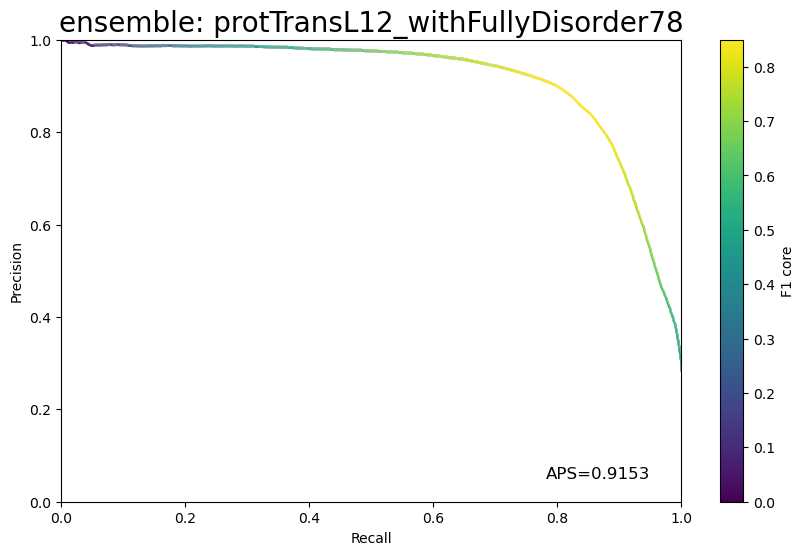

In [281]:
x = recall
y = precision
dydx = f1  # color values

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(10)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)

line = axs.add_collection(lc)

cbar = fig.colorbar(line, ax=axs)
cbar.set_label('F1 core')

axs.set_xlim(x.min(), x.max())
axs.set_xlabel('Recall')
axs.set_ylabel('Precision')
plt.text(0.95, 0.05, f'APS={round(aps, 4)}', fontsize=12, horizontalalignment='right')
plt.title(f'{ensemble_name}_{datasetType}', fontsize=20)
plt.show()

fig.savefig(f'CAID: PR-f1_{ensemble_name}_{datasetType}.jpg')

### 2.3.3. Best F1 Score

In [282]:
list_threshold = np.linspace(0, 1, num=101)
list_f1 = []
best_t = 0
best_f1 = 0
for t in list_threshold:
    list_all_predLabel = get_pred_label(list_all_pred, t)
    f1 = f1_score(list_all_label, list_all_predLabel)
    list_f1.append(f1)
    if f1>best_f1:
        best_t = t
        best_f1 = f1
print(f'best F1: {best_f1}, threshhold: {best_t}')

best F1: 0.8492799286202234, threshhold: 0.39


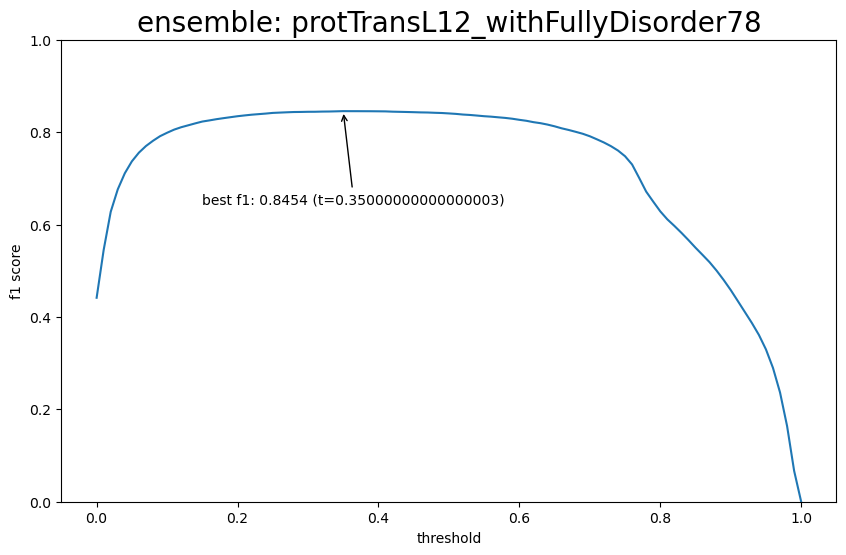

In [156]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()

x = list_threshold
y = list_f1

line = ax.plot(x, y)

ymax = max(y)
xpos = y.index(ymax)
xmax = x[xpos]

ax.annotate(f'best f1: {round(ymax, 4)} (t={xmax})', xy=(xmax, ymax), xytext=(xmax-0.2, ymax-0.2),
            arrowprops=dict(arrowstyle="->"),
            )
ax.set_title(f'F1 plot: {ensemble_name}')
ax.set_xlabel('threshold')
ax.set_ylabel('f1 score')
ax.set_ylim(0,1)
plt.title(f'{ensemble_name}_{datasetType}', fontsize=20)
plt.show()

fig.savefig(f'CAID: f1-t_{ensemble_name}_{datasetType}.jpg')

## 2.3. One Example

In [157]:
entity = list_entity[87]
entity_id = entity['id']
entity_seq = entity['sequence']

len(list_entity), entity_id

(348, 'DP02907')

**Get label**

In [158]:
label = get_label(entity)

### 2.3.1. prediction

In [159]:
# path_seq_embedded = os.path.join(paramF.path_embedded_protTrans, f'{entity_id}.npy')
# pred, pred_label = get_pred(path_seq_embedded, threshold)
print(f'best F1 score: {best_f1}, threshhold: {best_t}')

path_pred_caid = os.path.join(paramF.path_pred_files, f'caid_pred_{ensemble_name}.json')
list_predInfo = read_json2list(path_pred_caid)

best F1 score: 0.8454222970641417, threshhold: 0.35000000000000003


**Single Test Case**

In [63]:
entity = list_predInfo[87]
entity_id = entity['id']
pred = entity['true_pred']
label = entity['true_reference']
pred_label = get_pred_label(pred, best_t)
print(entity_id)

DP03067


**Error**

In [64]:
count_mispredict(pred_label, label), error_mispredict(pred_label, label)

(35, 0.5147058823529411)

**Plots**

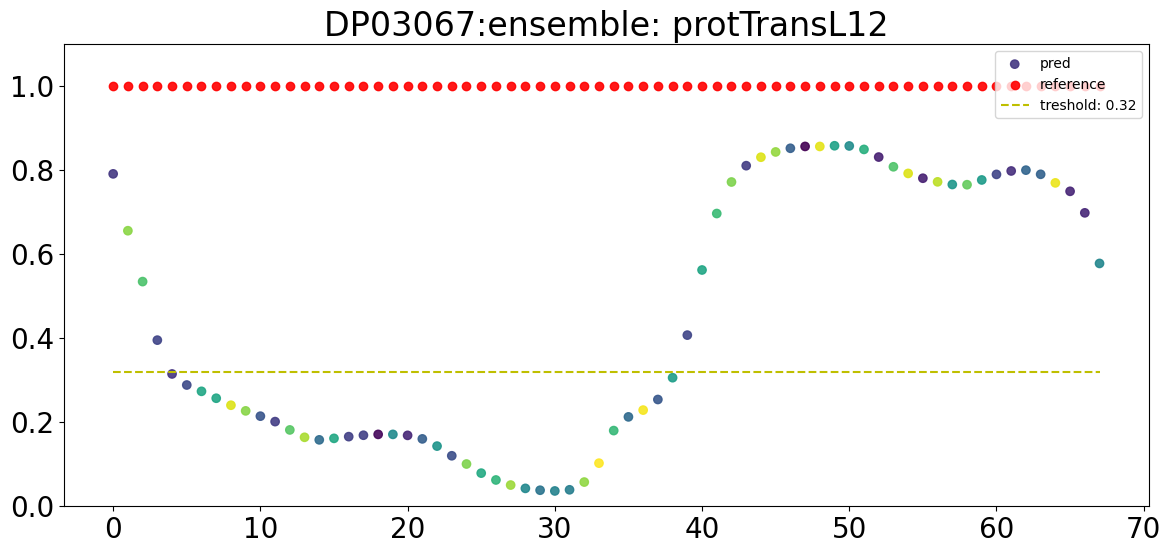

In [65]:
x = list(range(len(pred)))
plt.figure(figsize=(14, 6))
# font size
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

# random colors
colors = np.random.rand(len(pred))

# plt.scatter(x, pred, c=colors, alpha=0.5)
plt.scatter(x, pred, c=colors, alpha=0.9)
plt.scatter(x, label, c='red', alpha=0.9)
plt.plot(x, [best_t]*len(x), 'y--')

# Function add a legend  
plt.legend(["pred", "reference", f'treshold: {round(best_t, 2)}'], loc ="upper right", prop={'size': 10})
plt.ylim(0, 1.1)
# fig_name = '1fs1_d_P63208'
plt.title(f'{entity_id}:{ensemble_name}')
fig_name = entity_id
plt.savefig(os.path.join(paramF.path_pred_plot, f'{fig_name}-{ensemble_name}.png'))

plt.show()